# Model transferability estimation methodology on hand gesture recognition tasks

The official implementation of the experiments.

[BIBTEX]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys
import os

# modify the project path below accordingly
PATH = "/content/drive/MyDrive/HGR/gesture_face_features"

sys.path.append(os.path.join(PATH, "code", "main"))

# we are working with sign images
data_path = os.path.join(PATH, 'samples', 'sign')

# paths to save features and embeddings
feat_path = os.path.join(PATH, 'data', 'feats')
emb_path  = os.path.join(feat_path, 'embeddings')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

# loading modules from system path
from loader import SignImageFolder, ModelLoader
from participant import participants, filter_participants, filter_targets
from feature import extract_features, extract_model_features
from feature import filter_by_id, get_f_y_pred
from utils import get_predictions, decode_imagenet, delete_keys, keep_fc
# from mte import get_leep_score, get_nleep_score, score_MTE, LogME

In [ ]:
# https://umap-learn.readthedocs.io/en/latest/
!pip install -q umap-learn
!git clone -q https://github.com/thuml/LogME.git
!git clone -q https://github.com/thuml/Transfer-Learning-Library/

fatal: destination path 'LogME' already exists and is not an empty directory.
fatal: destination path 'Transfer-Learning-Library' already exists and is not an empty directory.


In [ ]:
MODEL_ZOO = ModelLoader.available_models
LAYER_ZOO = ['avgpool', 'features.8', 'Mixed_7c.branch_pool.conv', 'layer4.2.conv3', 'features.34'] # see ModelLoader.return_nodes_dict
METHOD_ZOO = ['umap', 'tsne', 'pca']
SCORE_ZOO = ['score', 'nleep']

In [6]:
dataset = SignImageFolder(data_path, resize=(528,528))
dataloader = DataLoader(dataset, batch_size=16, num_workers=2)
print(f"Count: {len(dataset)}")

NameError: name 'SignImageFolder' is not defined

## CAM

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
m = ModelLoader('resnet50')
model = m.model

In [ ]:
num_classes = len(dataset.classes)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=5):
    model.train()

    for epoch in range(num_epochs):
      running_loss = 0.0
      for images, labels, _ in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

    print("Training Complete")

# Train for 5 epochs
train_model(model, dataloader, criterion, optimizer, num_epochs=50)

Epoch 1/50, Loss: 2.0262733422792873
Epoch 2/50, Loss: 1.9735457713787372
Epoch 3/50, Loss: 1.967444318991441
Epoch 4/50, Loss: 1.9560250685765193
Epoch 5/50, Loss: 1.9445787026331975
Epoch 6/50, Loss: 1.929874952022846
Epoch 7/50, Loss: 1.9006441739889293
Epoch 8/50, Loss: 1.8613045032207782
Epoch 9/50, Loss: 1.7624183984903188
Epoch 10/50, Loss: 1.6857914924621582
Epoch 11/50, Loss: 1.817165805743291
Epoch 12/50, Loss: 1.9210948944091797


In [ ]:
def predict(model, dataloader):
    model.eval()  # Set model to evaluation mode
    predictions = []
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient tracking
        for images, labels, _ in dataloader:  # Include labels
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability

            predictions.extend(predicted.cpu().numpy())  # Store predictions

            # Accuracy Calculation
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")  # Print accuracy

    return predictions

# Get predictions & accuracy
preds = predict(model, dataloader)
print("Predictions:", preds)

In [ ]:
model_path = os.path.join(data_path, 'models', 'efficientnet_model.pth')
torch.save(model.state_dict(), model_path)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set to eval mode before making predictions

In [ ]:
# AUGMENTATION

# from PIL import Image

# colors = [
#     [255, 0, 0],    # Bright Red
#     [0, 255, 0],    # Lime Green
#     [0, 191, 255],  # Sky Blue
#     [255, 223, 0],  # Golden Yellow
#     [128, 0, 128],  # Deep Purple
#     [64, 224, 208], # Turquoise
#     [255, 105, 180] # Hot Pink
# ]

# for i in range(len(dataset)):
#   img_pil, label, id = dataset[i]
#   img_np = np.array(img_pil)
#   mask = np.all(img_np < 65, axis=-1)
#   mask[:200, :] = False
#   img_np[mask] = colors[i % 7]
#   img_np = img_np.astype(np.uint8)
#   filename = f"IMG_-{id}.JPG"
#   filepath = os.path.join(data_path, dataset.idx_to_class[label], filename)
#   img = Image.fromarray(img_np)
#   img.save(filepath)

In [ ]:
feats = extract_model_features(dataloader, feat_path=feat_path)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:11<00:00, 50.2MB/s]


Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/vgg19_feats.pt.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.7MB/s]


Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/resnet50_feats.pt.


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 66.3MB/s]


Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/inception_v3_feats.pt.


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 24.5MB/s]


Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/efficientnet_b0_feats.pt.


Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 83.7MB/s]


Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/efficientnet_b1_feats.pt.


Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-24a108a5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-24a108a5.pth
100%|██████████| 165M/165M [00:02<00:00, 84.5MB/s]


Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/efficientnet_b6_feats.pt.


# Initial MTE rankings

In [ ]:
%cd Transfer-Learning-Library
from tllib.ranking.hscore import h_score, regularized_h_score
from tllib.ranking.transrate import transrate
from tllib.ranking.logme import log_maximum_evidence
from tllib.ranking.leep import log_expected_empirical_prediction

/content/Transfer-Learning-Library


In [ ]:
def mte_score_models(model_name_list, feats, targets, verbose=True):
  model_scores = {
    "LEEP": {},
    "LogME": {},
    "H-Score": {},
    "Regularized H-Score": {},
    "Transrate": {}
  }

  for model_name in model_name_list:
    print(f'Calculating scores for {model_name}...')
    f, y, preds, idx = get_f_y_pred(model_name, feats, targets)

    model_scores["LEEP"][model_name] = log_expected_empirical_prediction(preds.numpy(), y)
    model_scores["LogME"][model_name] = log_maximum_evidence(f, y)
    model_scores["H-Score"][model_name] = h_score(f, y)
    model_scores["Regularized H-Score"][model_name] = regularized_h_score(f, y)
    model_scores["Transrate"][model_name] = transrate(f, y)

  ranked_scores = {}
  for key in model_scores:
    ranked_scores[key] = sorted(model_scores[key].items(), key=lambda x: x[1], reverse=True)

  if verbose:
    for metric, models in ranked_scores.items():
      print(f"\nRanked Models by {metric}:")
      for rank, (model, score) in enumerate(models, start=1):
        print(f"{rank}. {model}: {score}")
      print()

  return ranked_scores

In [ ]:
# ranked_models = mte_score_models(MODEL_ZOO, feats, dataset.targets);

In [ ]:
# for model_name in MODEL_ZOO:
#   _, _, _, idx = get_f_y_pred(model_name, feats, dataset.targets)
#   label_counts, _ = decode_imagenet(idx)
#   print(f'Predictions of {model_name}: {label_counts}')

In [ ]:
# Deletes all features except for avgpool to free RAM
# for model_name in MODEL_ZOO:
#   delete_keys(feats[model_name], keep_key_list=['avgpool'])

In [ ]:
# splitting feats based on participants
p = filter_participants(feats, dataset)
t = filter_targets(dataset)

In [ ]:
del feats # frees up RAM

In [ ]:
# part_mte_scores = []
# for i in range(6):
#   print(f'--------------Participant {i}---------------')
#   part_mte_scores.append(mte_score_models(MODEL_ZOO, p[i], t[i]))

In [ ]:
# for i in range(6):
#   print(part_mte_scores[i]['Transrate'][:1])

In [ ]:
import umap
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter("ignore", FutureWarning)

class Reducer:
  def __init__(self, feats, targets, model_name, layer_name, method='umap', n_components=2, random_state=None, emb_path=None):
    self.feats = feats
    self.targets = targets
    self.model_name = model_name
    self.layer_name = layer_name
    self.random_state = random_state
    self.n_components = n_components
    self.embedding = None
    self.params = None
    self.method = method
    self.layer_feats = self._get_layer_feats()
    self.emb_path = emb_path

  def _get_layer_feats(self):
    layer_feats = self.feats[self.model_name][self.layer_name]
    return layer_feats.view(layer_feats.shape[0], -1)

  def _get_file_name(self):
    return  f"{self.method}_{self.model_name}_{self.layer_name}_rs_{str(self.random_state)}.npz"

  def _get_key_name(self, params):
    return ' '.join(str(value) for value in params.values())

  def get_embedding(self, params=None):
    # print(params)
    if self.method == 'umap':
      self.params = params or {
        'n_neighbors': 30,
        'min_dist': 0.3,
        'metric': 'euclidean',
      }
      reducer = umap.UMAP(
        n_components=self.n_components,
        n_neighbors=self.params['n_neighbors'],
        min_dist=self.params['min_dist'],
        metric=self.params['metric'],
        random_state=self.random_state
      )
    elif self.method == 'tsne':
      self.params = params or {
        'perplexity': 10,
        'learning_rate': 300,
        'metric': 'euclidean',
      }
      reducer = TSNE(
        n_components=self.n_components,
        perplexity=self.params['perplexity'],
        learning_rate=self.params['learning_rate'],
        metric=self.params['metric'],
        random_state=self.random_state
      )
    elif self.method == 'pca':
      self.params = params or {
          'whiten': False,
          'svd_solver': 'full',
      }
      reducer = PCA(
          n_components=self.n_components,
          whiten=self.params['whiten'],
          svd_solver=self.params['svd_solver'],
          random_state=self.random_state
      )

    self.embedding = reducer.fit_transform(self.layer_feats)

  def get_embedding_from_disk(self, params, verbose=False):
    if not self.emb_path or not params:
      print('No path or params to load form disk.')
      return

    file_name = self._get_file_name()
    key_name = self._get_key_name(params)
    file_path = os.path.join(self.emb_path, file_name)

    if os.path.exists(file_path):
      with np.load(file_path, allow_pickle=True) as f:
        data = dict(f)
        if key_name in data:
          self.embedding = data[key_name]
          self.params = params
          if verbose:
            print(f'Data loaded for {file_name}')
        else:
          self.get_embedding(params)
          data[key_name] = self.embedding
          np.savez(file_path, **data)
          if verbose:
            print(f"Data saved to {file_path}.")
        del data
    else:
      self.get_embedding(params)
      np.savez(file_path, **{key_name: self.embedding})
      if verbose:
        print(f"Data saved to {file_path}.")

  def plot(self, idx_to_class=None):
      scatter = plt.scatter(
        self.embedding[:, 0],
        self.embedding[:, 1],
        c=self.targets,
        cmap='viridis'
      )

      unique_targets = np.unique(self.targets)
      handles = []
      for target in unique_targets:
        letter = idx_to_class[target] if idx_to_class else target
        handle = plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=plt.cm.viridis(target / max(unique_targets)),
                            markersize=10, label=letter)
        handles.append(handle)

      plt.xticks([])
      plt.yticks([])
      plt.legend(handles=handles, title="Letters", loc='lower right')
      plt.show()

  def __repr__(self):
    return f"Embedding shape: {self.embedding.shape}, {self.method} params: {self.params})"

class ReducerEngine:
  def __init__(self, feats, targets, method='umap', param_grids=None, n_components=2, random_state=None, emb_path=None):
    self.feats = feats
    self.targets = np.array(targets)
    self.method = method
    self.param_grids = param_grids or {
      'umap': {
        'n_neighbors': [5, 10, 15, 30],
        'min_dist': [0.01, 0.05, 0.1, 0.3],
        'metric': ["euclidean", "cosine"]
      },
      'tsne': {
        'perplexity': [10, 15, 20, 25],
        'learning_rate': [100, 300, 600, 1000],
        'metric': ["euclidean", "cosine"]
      },
      'pca': {
        'whiten': [True, False],
        'svd_solver': ['full', 'auto'],
      }
    }
    self.n_components = n_components
    self.random_state = random_state
    self.reducers = []
    self.emb_path = emb_path

  def get_all_embeddings(self, model_name_list, layer_name_list, from_disk=True):
    print(f'Getting {self.method} embeddings for grid {self.param_grids[self.method]}.')
    for model_name in model_name_list:
      for layer_name in layer_name_list:
        if layer_name in self.feats[model_name].keys():
          # print(f'-------- {model_name} {layer_name} ---------')
          for params in ParameterGrid(self.param_grids[self.method]):
            reducer = Reducer(self.feats, self.targets, model_name, layer_name, self.method, self.n_components, self.random_state, self.emb_path)
            if from_disk:
              reducer.get_embedding_from_disk(params, verbose=False)
            else:
              reducer.get_embedding(params)
            self.reducers.append(reducer)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import torchvision.transforms as T
import math

class Embedding:
  def __init__(self, reducer, model='kmeans', n_clusters=None, random_state=None):
    self.reducer = reducer
    self.random_state = random_state
    self.model = model
    self.cluster = None
    self.n_clusters = n_clusters or len(np.unique(self.reducer.targets))
    self.img_id_clusters = [[] for _ in range(self.n_clusters)]

  def get_clusters(self):
    if self.model == 'kmeans':
      model = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
    elif self.model == 'gmm':
      model = GaussianMixture(n_components=self.n_clusters, random_state=self.random_state)
    self.cluster = model.fit_predict(self.reducer.embedding)

  def get_img_ids(self, dataset):
    for i in range(len(dataset)):
      self.img_id_clusters[self.cluster[i]].append(dataset.img_ids[i])
    return self.img_id_clusters

  def plot_imgs(self, dataset, cluster_num, count=5, resize=(100,100)):
    img_ids = self.img_id_clusters[cluster_num]
    resize_transform = T.Resize(resize)
    num_images = len(img_ids[:count])
    rows = math.ceil(num_images / 5)
    cols = min(5, num_images)
    plt.figure(figsize=(cols * 3, rows * 3))
    print(f'Plotting cluster {cluster_num} for ids {img_ids}')
    for i, id in enumerate(img_ids[:count]):
        idx = dataset.img_ids.index(id)
        img_tensor = dataset[idx][0]
        resized_img = resize_transform(img_tensor.unsqueeze(0)).squeeze(0)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(resized_img.permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.tight_layout()
    plt.show()


  def __repr__(self):
    return f"Embedding for {self.model}"

class EmbeddingEngine:
  def __init__(self, reducer_engine, model='kmeans', n_clusters=None, random_state=None):
    self.reducer_engine = reducer_engine
    self.random_state = random_state
    self.model = model
    self.clusters = []
    self.n_clusters = n_clusters

  def get_all_clusters(self):
    print(f'Getting {self.model} clusters...')
    for reducer in self.reducer_engine.reducers:
      # print(f'-------- {reducer.model_name} {reducer.layer_name} ---------')
      cluster = Embedding(reducer, self.model, self.n_clusters, self.random_state)
      cluster.get_clusters()
      self.clusters.append(cluster)

In [ ]:
import itertools
from collections import Counter

class Cluster:
  def __init__(self, embedding, idx_to_class=None):
    self.embedding = embedding
    self.idx_to_class = idx_to_class or {
        0: 'A', 1: 'H', 2: 'L',
        3: 'N', 4: 'O', 5: 'P', 6: 'R'
    }
    self.similarity_scores = self._build_similarity_scores()
    self.cluster_groups = self.group()
    self.score = self.evaluate()
    self.purity = self.get_purity()
    self.nleep_score = 0

  def _build_similarity_scores(self):
    similarity_scores = {
      ("R", "N"): 0.8,
      ("H", "P"): 0.8,
      ("P", "L"): 0.8,
      ("R", "O"): 0.6,
      ("N", "O"): 0.6,
      ("H", "L"): 0.6,
    }
    similarity_scores.update({(b, a): score for (a, b), score in similarity_scores.items()})
    for letter in 'AHLNPRO':
        similarity_scores[(letter, letter)] = 1.0
    return similarity_scores

  def evaluate(self):
    count = self.embedding.n_clusters
    total = sum(self.eval_single(i) for i in range(count))
    return total/count

  def eval_single(self, cluster_num):
    letters = list(self.cluster_groups.values())[cluster_num]
    # if a single letter in a cluster then score is 0
    if len(letters) == 1:
      return 0
    pairs = list(itertools.combinations(letters, 2))
    score = sum(self.similarity_scores.get(pair, 0) for pair in pairs)/len(pairs)
    return score

  def group(self):
    data = np.column_stack((self.embedding.cluster, self.embedding.reducer.targets))
    cluster_groups = {}
    for cluster, target in data:
        cluster_groups.setdefault(cluster, []).append(self.idx_to_class[target])
    return cluster_groups

  def get_purity(self):
    total_samples = len(self.embedding.reducer.targets)
    return sum(max(Counter(letter_group).values()) for letter_group in self.cluster_groups.values()) / total_samples

  def __repr__(self):
      cluster_details = f"-------{self.embedding.reducer.model_name} "
      cluster_details += f"{self.embedding.reducer.layer_name}-------\n\n"
      for cluster, letter_group in self.cluster_groups.items():
          cluster_details += f"Cluster {cluster}: {letter_group}\n"
      cluster_details += f"\nPurity: {self.purity:.2f}\n"
      cluster_details += f"Custom Weighted Score: {self.score:.2f}\n"
      return cluster_details


class ClusterEngine:
  def __init__(self, embedding_engine):
    self.embedding_engine = embedding_engine
    self.scored_clusters = []
    self.best_cluster = None
    self.best_score = 0

  def score_all_clusters(self):
    print(f'Getting cluster scores...')
    for embedding in self.embedding_engine.clusters:
      # print(f'-------- {model_name} {layer_name} ---------')
      cluster = Cluster(embedding)
      # print(cluster)
      self.scored_clusters.append(cluster)
      if cluster.score > self.best_score:
        self.best_score = cluster.score
        self.best_cluster = cluster


In [ ]:
from LogME.LEEP import LEEP

class Engine:
  def __init__(self, reducer_engine, model='kmeans', n_clusters=None, random_state=None):
    self.re = reducer_engine
    self.ee = None
    self.ce = None
    self.model = model
    self.random_state = random_state
    self.ranked_clusters = {}
    self.n_clusters = n_clusters

  def run(self, model_name_list):
    self.score(verbose=False)
    self.rank(model_name_list, 'score')
    self.rank(model_name_list, 'nleep')

  def score(self, verbose=True):
    self.ee = EmbeddingEngine(self.re, self.model, self.n_clusters, self.random_state)
    self.ee.get_all_clusters()
    self.ce = ClusterEngine(self.ee)
    self.ce.score_all_clusters()
    self.get_nleep_scores()
    if verbose:
      print(self.ce.best_cluster)
      self.ce.best_cluster.embedding.reducer.plot()

  def get_nleep_scores(self, factor=1):
    print('Getting cluster nleep scores...')
    for cluster in self.ce.scored_clusters:
      self.get_nleep_score(cluster, factor)

  def get_nleep_score(self, cluster=None, factor=1, random_state=None):
    cluster = cluster or self.ce.best_cluster
    n_components = cluster.embedding.n_clusters * factor
    embedding = cluster.embedding.reducer.embedding
    random_state = random_state or self.random_state
    targets = cluster.embedding.reducer.targets

    gmm = GaussianMixture(n_components=n_components, random_state=random_state)
    gmm.fit(embedding)
    gmm_predictions = gmm.predict_proba(embedding)
    cluster.nleep_score = LEEP(gmm_predictions, targets)
    return cluster.nleep_score

  def corr(self):
    self.nleep_scores = [cluster.nleep_score for cluster in self.ce.scored_clusters]
    self.scores = [cluster.score for cluster in self.ce.scored_clusters]
    correlation = np.corrcoef(self.scores, self.nleep_scores)[0, 1]
    print(f"Pearson Correlation: {correlation}")
    plt.scatter(self.scores, self.nleep_scores)

  def get_best_cluster(self, model_name, method='score'):
    best_score = float('-inf')
    best_cluster = None
    for cluster in self.ce.scored_clusters:
      if model_name == cluster.embedding.reducer.model_name:
        if method == 'score':
          score = cluster.score
        elif method == 'nleep':
          score = cluster.nleep_score
        else:
          raise ValueError('Method must be "nleep" or "score".')
        if score > best_score:
          best_score = score
          best_cluster = cluster
    return best_cluster

  def rank(self, model_name_list, method='score'):
    clusters = []
    for model_name in model_name_list:
      best_cluster = self.get_best_cluster(model_name, method)
      clusters.append(best_cluster)
    clusters = sorted(clusters, key=lambda cluster: cluster.nleep_score if method == 'nleep' else cluster.score, reverse=True)
    self.ranked_clusters[method] = clusters

  def plot_ranking(self, method='nleep'):
    rows = []
    for cluster in self.ranked_clusters[method]:
      score = cluster.nleep_score if method == 'nleep' else cluster.score
      model_name = cluster.embedding.reducer.model_name
      layer_name = cluster.embedding.reducer.layer_name
      params = cluster.embedding.reducer.params
      mean = self.get_model_mean(model_name, method)
      rows.append({'model': model_name, 'layer': layer_name, 'params': params,
                  method: round(score, 2), 'mean': mean})
    return pd.DataFrame(rows)

  def get_model_mean(self, model_name, method='nleep'):
    sum = 0
    count = 0
    for cluster in self.ce.scored_clusters:
      if model_name == cluster.embedding.reducer.model_name:
        score = cluster.nleep_score if method == 'nleep' else cluster.score
        sum += score
        count += 1
    return sum / count


In [ ]:
# def get_h_score(cluster):
#   embedding = cluster.embedding.reducer.embedding
#   targets = cluster.embedding.reducer.targets
#   cluster.h_score = hscore.h_score(embedding, targets)
#   return cluster.h_score

In [ ]:
# for cluster in engines[0]['umap'].ce.scored_clusters:
#   get_h_score(cluster)

In [ ]:
# h_scores = []
# nleep_scores = []
# scores = []

# for cluster in engines[0]['umap'].ce.scored_clusters:
#   h_scores.append(cluster.h_score)
#   nleep_scores.append(cluster.nleep_score)
#   scores.append(cluster.score)

In [ ]:
engines = []
for i in range(6):
  print(f'\n------- Participant {i}---------')
  engines.append({})
  for method in METHOD_ZOO:
    re = ReducerEngine(p[i], t[i], method=method, n_components=2, emb_path=os.path.join(emb_path, str(i)))
    re.get_all_embeddings(MODEL_ZOO, LAYER_ZOO)
    e = Engine(re, 'kmeans')
    e.score(verbose=False)
    e.rank(MODEL_ZOO, 'score')
    e.rank(MODEL_ZOO, 'nleep')
    engines[i][method] = e


------- Participant 0---------
Getting umap embeddings for grid {'n_neighbors': [5, 10, 15, 30], 'min_dist': [0.01, 0.05, 0.1, 0.3], 'metric': ['euclidean', 'cosine']}.
Getting kmeans clusters...
Getting cluster scores...
Getting cluster nleep scores...
Getting tsne embeddings for grid {'perplexity': [10, 15, 20, 25], 'learning_rate': [100, 300, 600, 1000], 'metric': ['euclidean', 'cosine']}.
Getting kmeans clusters...
Getting cluster scores...
Getting cluster nleep scores...
Getting pca embeddings for grid {'whiten': [True, False], 'svd_solver': ['full', 'auto']}.
Getting kmeans clusters...
Getting cluster scores...
Getting cluster nleep scores...

------- Participant 1---------
Getting umap embeddings for grid {'n_neighbors': [5, 10, 15, 30], 'min_dist': [0.01, 0.05, 0.1, 0.3], 'metric': ['euclidean', 'cosine']}.
Getting kmeans clusters...
Getting cluster scores...
Getting cluster nleep scores...
Getting tsne embeddings for grid {'perplexity': [10, 15, 20, 25], 'learning_rate': [100

In [ ]:
for i in range(6):
  print(f'Participant {i}')
  for method in METHOD_ZOO:
    cluster = engines[i][method].ce.best_cluster
    print(f'Best {method} score: {cluster.score:.4f} {cluster.embedding.reducer.params}')
    print(f'{cluster.embedding.reducer.model_name} {cluster.embedding.reducer.layer_name}')
  print()

Participant 0
Best umap score: 0.6893 {'metric': 'euclidean', 'min_dist': 0.05, 'n_neighbors': 15}
efficientnet_b6 avgpool
Best tsne score: 0.6521 {'learning_rate': 100, 'metric': 'cosine', 'perplexity': 10}
efficientnet_b6 avgpool
Best pca score: 0.5176 {'svd_solver': 'auto', 'whiten': True}
efficientnet_b6 avgpool

Participant 1
Best umap score: 0.8578 {'metric': 'cosine', 'min_dist': 0.01, 'n_neighbors': 5}
inception_v3 avgpool
Best tsne score: 0.7848 {'learning_rate': 100, 'metric': 'cosine', 'perplexity': 10}
efficientnet_b1 avgpool
Best pca score: 0.7451 {'svd_solver': 'auto', 'whiten': True}
efficientnet_b1 avgpool

Participant 2
Best umap score: 0.8021 {'metric': 'cosine', 'min_dist': 0.1, 'n_neighbors': 5}
efficientnet_b6 avgpool
Best tsne score: 0.7622 {'learning_rate': 100, 'metric': 'euclidean', 'perplexity': 15}
resnet50 avgpool
Best pca score: 0.6314 {'svd_solver': 'auto', 'whiten': True}
efficientnet_b1 avgpool

Participant 3
Best umap score: 0.8786 {'metric': 'euclidean

In [ ]:
engines[0]['tsne'].ce.best_cluster.embedding.reducer.params

{'learning_rate': 100, 'metric': 'cosine', 'perplexity': 10}

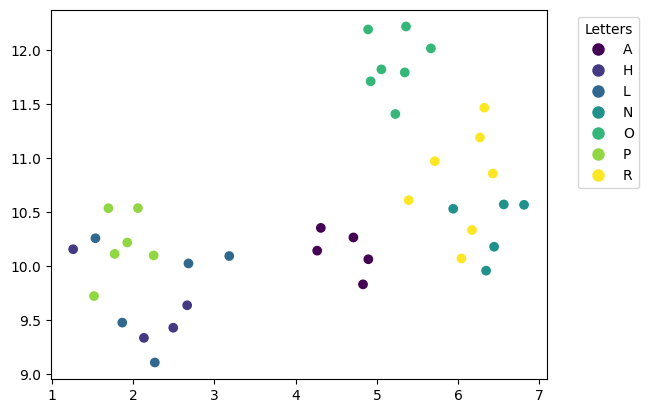

In [ ]:
engines[5]['umap'].ce.best_cluster.embedding.reducer.plot(dataset.idx_to_class)

In [ ]:
engines_gmm = []
for i in range(6):
  print(f'\n------- Participant {i}---------')
  engines_gmm.append({})
  for method in METHOD_ZOO:
    re = ReducerEngine(p[i], t[i], method=method, n_components=2, emb_path=os.path.join(emb_path, str(i)))
    re.get_all_embeddings(MODEL_ZOO, LAYER_ZOO)
    e = Engine(re, 'gmm')
    e.score(verbose=False)
    e.rank(MODEL_ZOO, 'score')
    e.rank(MODEL_ZOO, 'nleep')
    engines_gmm[i][method] = e

Streaming output truncated to the last 5000 lines.
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected: 7
Actual clusters available: 7
Total clusters expected:

In [ ]:
for i in range(6):
  print(f'Participant {i}')
  for method in METHOD_ZOO:
    cluster = engines_gmm[i][method].ce.best_cluster
    print(f'Best {method} score: {cluster.score:.4f} {cluster.embedding.reducer.params}')
    print(f'{cluster.embedding.reducer.model_name} {cluster.embedding.reducer.layer_name}')
  print()

Participant 0
Best umap score: 0.7483 {'metric': 'cosine', 'min_dist': 0.1, 'n_neighbors': 5}
inception_v3 avgpool
Best tsne score: 0.6900 {'learning_rate': 100, 'metric': 'euclidean', 'perplexity': 10}
resnet50 avgpool
Best pca score: 0.5568 {'svd_solver': 'full', 'whiten': False}
resnet50 avgpool

Participant 1
Best umap score: 0.8648 {'metric': 'euclidean', 'min_dist': 0.05, 'n_neighbors': 5}
efficientnet_b6 avgpool
Best tsne score: 0.8310 {'learning_rate': 100, 'metric': 'euclidean', 'perplexity': 15}
efficientnet_b6 avgpool
Best pca score: 0.6615 {'svd_solver': 'auto', 'whiten': False}
efficientnet_b6 avgpool

Participant 2
Best umap score: 0.7857 {'metric': 'euclidean', 'min_dist': 0.01, 'n_neighbors': 5}
efficientnet_b6 avgpool
Best tsne score: 0.7600 {'learning_rate': 100, 'metric': 'euclidean', 'perplexity': 20}
efficientnet_b1 avgpool
Best pca score: 0.6225 {'svd_solver': 'full', 'whiten': True}
efficientnet_b1 avgpool

Participant 3
Best umap score: 0.8762 {'metric': 'euclid

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot(embedding, targets, idx_to_class=None):
    scatter = plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=targets,
        cmap='viridis'
    )

    plt.xticks([])
    plt.yticks([])

    unique_targets = np.unique(targets)
    handles = []
    for target in unique_targets:
        letter = idx_to_class[target] if idx_to_class else target
        handle = plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=plt.cm.viridis(target / max(unique_targets)),
                            markersize=10, label=letter)
        handles.append(handle)

    plt.legend(handles=handles, title="Letters", loc='lower right')
    plt.show()

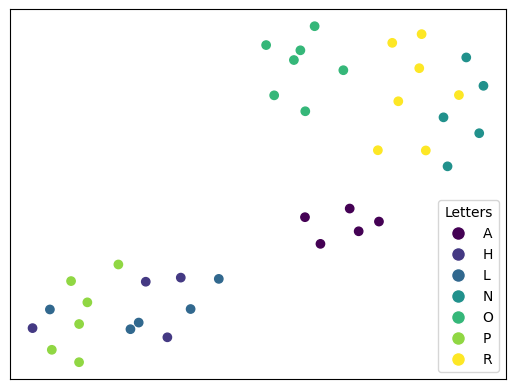

In [ ]:
plot(engines_gmm[5]['umap'].ce.best_cluster.embedding.reducer.embedding, t[5], dataset.idx_to_class)

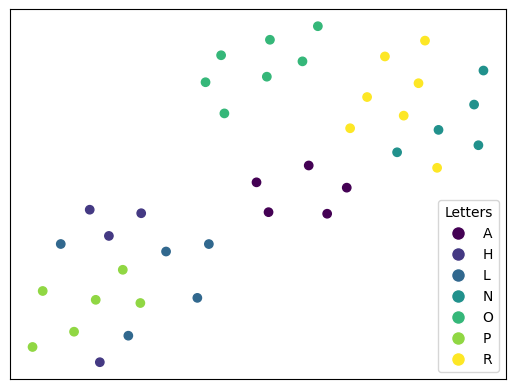

In [ ]:
plot(engines[5]['tsne'].ce.best_cluster.embedding.reducer.embedding, t[5], dataset.idx_to_class)

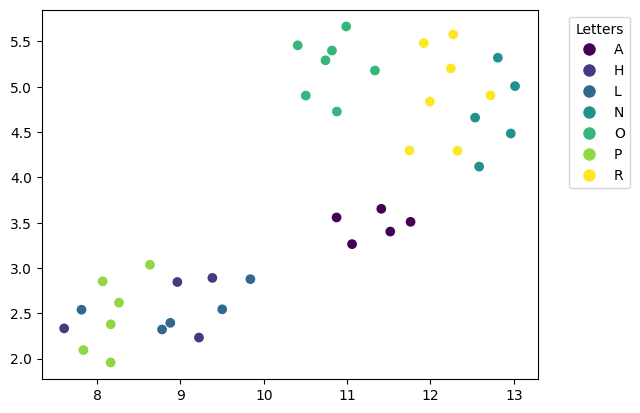

In [ ]:
engines_gmm[5]['umap'].ce.best_cluster.embedding.reducer.plot(dataset.idx_to_class)

In [ ]:
def get_nleep_score(cluster):
  cluster = cluster
  n_components = 7
  embedding = cluster.embedding.reducer.embedding
  targets = cluster.embedding.reducer.targets

  gmm = GaussianMixture(n_components=n_components)
  gmm.fit(embedding)
  gmm_predictions = gmm.predict_proba(embedding)
  cluster.nleep_score = LEEP(gmm_predictions, targets)
  return cluster.nleep_score

Pearson Correlation: 0.8308163736455035


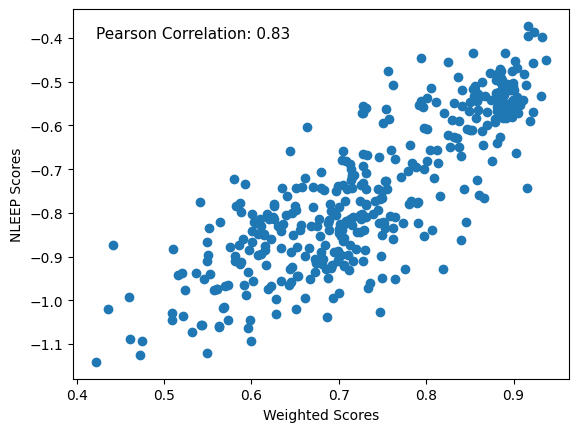

In [ ]:
nleep_scores = [cluster.nleep_score for cluster in e.ce.scored_clusters]
scores = [cluster.score for cluster in e.ce.scored_clusters]
correlation = np.corrcoef(scores, nleep_scores)[0, 1]
print(f"Pearson Correlation: {correlation}")
plt.text(min(scores), max(nleep_scores), f'Pearson Correlation: {correlation:.2f}',
         fontsize=11, color='black', ha='left', va='top')
# plt.xticks([])
plt.xlabel('Weighted Scores')
plt.ylabel('NLEEP Scores')
# plt.yticks([])
plt.scatter(scores, nleep_scores)

In [ ]:
for i in range(6):
  for method in METHOD_ZOO:
    e = engines[i][method]
    for cluster in e.ce.scored_clusters:
      get_nleep_score(cluster)

In [ ]:
engines[5]['pca'].plot_ranking()

,model,layer,params,nleep,mean
0,efficientnet_b0,avgpool,"{'svd_solver': 'full', 'whiten': True}",-0.42,-0.736436
1,vgg19,avgpool,"{'svd_solver': 'full', 'whiten': False}",-0.88,-0.948471
2,resnet50,avgpool,"{'svd_solver': 'auto', 'whiten': True}",-0.80,-0.897418
3,efficientnet_b6,avgpool,"{'svd_solver': 'auto', 'whiten': False}",-0.71,-0.901972
4,efficientnet_b1,avgpool,"{'svd_solver': 'auto', 'whiten': True}",-0.65,-0.837472
5,inception_v3,avgpool,"{'svd_solver': 'auto', 'whiten': True}",-0.82,-0.795540


In [ ]:
engines[5]['umap'].score()

Pearson Correlation: 0.36162662073199064


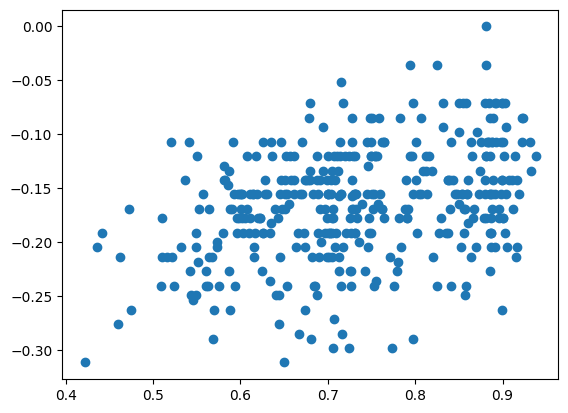

In [ ]:
engines[5]['umap'].corr()

In [ ]:
engines_gmm[5]['tsne'].ce.best_cluster

-------resnet50 avgpool-------

Cluster 5: ['O', 'O', 'O', 'O']
Cluster 3: ['O', 'O', 'O']
Cluster 2: ['R', 'R', 'N', 'N', 'N', 'N']
Cluster 0: ['R', 'R', 'R', 'R', 'R', 'N']
Cluster 4: ['L', 'L', 'L', 'L', 'P', 'H', 'H', 'H']
Cluster 1: ['L', 'P', 'P', 'P', 'P', 'P', 'H']
Cluster 6: ['A', 'A', 'A', 'A', 'A']

Purity: 0.77
Custom Weighted Score: 0.93

In [ ]:
def count_best_models(method_list, score_list, top_n=1):
  counts = {model: 0 for model in MODEL_ZOO}
  for i in range(1,2):
    print(f'Participant {i}')
    for method in method_list:
      for score in score_list:
        ranked_clusters_kmeans = engines[i][method].ranked_clusters[score]
        ranked_clusters_gmm = engines_gmm[i][method].ranked_clusters[score]
        for cluster in ranked_clusters_kmeans[:top_n]:
          model_name = cluster.embedding.reducer.model_name
          counts[model_name] += 1
        for cluster in ranked_clusters_gmm[:top_n]:
          model_name = cluster.embedding.reducer.model_name
          counts[model_name] += 1
  return counts

In [ ]:
count_best_models(['umap', 'tsne'], SCORE_ZOO)

Participant 2


{'vgg19': 1,
 'resnet50': 3,
 'inception_v3': 0,
 'efficientnet_b0': 1,
 'efficientnet_b1': 1,
 'efficientnet_b6': 2}

# Model Transferability Estimation

https://github.com/thuml/Transfer-Learning-Library/tree/master/examples/model_selection

In [ ]:
# targets = np.array(dataset.targets, dtype=np.int32)
# for model_name in MODEL_ZOO:
#   fc_layer = list(feats[model_name].keys())[-1]
#   f = feats[model_name][fc_layer]
#   # preds = F.softmax(f, dim=1).numpy()
#   score = get_nleep_score(f, targets, 35)
#   print(f'NLEEP score for {model_name}: {score}')

NLEEP score for vgg19: -1.1026206016540527
NLEEP score for resnet50: -1.0406854152679443
NLEEP score for inception_v3: -1.1728464365005493
NLEEP score for efficientnet_b0: -1.062324047088623
NLEEP score for efficientnet_b1: -1.0187960863113403
NLEEP score for efficientnet_b6: -1.144242525100708


In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.mixture import GaussianMixture
# import numpy as np

# random_state = 42
# num_components_pca = 35  # Number of components for PCA (adjust as needed)

# targets = np.array(dataset.targets, dtype=np.int32)
# for model_name in MODEL_ZOO:
#   fc_layer = list(feats[model_name].keys())[-1]
#   f = feats[model_name][fc_layer]
#   # preds = F.softmax(f, dim=1).numpy()
#   pca = PCA(n_components=num_components_pca, random_state=random_state)
#   reduced_features = pca.fit_transform(f)

#   explained_variance_ratio = pca.explained_variance_ratio_
#   pca_energy = np.cumsum(explained_variance_ratio)

#   num_components_gmm = 35
#   gmm = GaussianMixture(n_components=num_components_gmm, random_state=random_state)
#   gmm.fit(reduced_features)
#   gmm_predictions = gmm.predict_proba(reduced_features)
#   nleep = get_leep_score(gmm_predictions.astype('float32'), targets)
#   # print("PCA Explained Variance Ratio:", np.sum(pca.explained_variance_ratio_), pca_energy)
#   print(f"NLEEP Score for {model_name}: {nleep}")

NLEEP Score for vgg19: -1.0961130857467651
NLEEP Score for resnet50: -1.0729265213012695
NLEEP Score for inception_v3: -1.0495256185531616
NLEEP Score for efficientnet_b0: -1.0380001068115234
NLEEP Score for efficientnet_b1: -0.8942098617553711
NLEEP Score for efficientnet_b6: -1.0076889991760254


In [ ]:
!git clone -q https://github.com/thuml/LogME.git

In [ ]:
from LogME.LogME import LogME
from LogME.LEEP import LEEP
from LogME.NCE import NCE

In [ ]:
targets = np.array(dataset.targets)
for model_name in MODEL_ZOO:
  fc_layer = list(feats[model_name].keys())[-1]
  f = feats[model_name][fc_layer]
  preds = F.softmax(f, dim=1).numpy()
  score = LEEP(preds, targets)
  print(f'LEEP score for {model_name}: {score}')

LEEP score for vgg19: -1.92770825355806
LEEP score for resnet50: -1.9434076109575982
LEEP score for inception_v3: -1.9360990636225066
LEEP score for efficientnet_b0: -1.9289171695876328
LEEP score for efficientnet_b1: -1.9320151866958826
LEEP score for efficientnet_b6: -1.9137111650971603


In [ ]:
logme = LogME()

targets = np.array(dataset.targets)
for model_name in MODEL_ZOO:
  fc_layer = list(feats[model_name].keys())[-1]
  f = feats[model_name][fc_layer]
  preds = F.softmax(f, dim=1).numpy()
  score = logme.fit(preds, targets)
  print(f'LogME score for {model_name}: {score}')

LogME score for vgg19: -2.257169256187553
LogME score for resnet50: -5.491077958443078
LogME score for inception_v3: -6.446164371475224


/content/LogME/LogME.py:172: UserWarning: re-fitting for new data. old parameters cleared.
  warnings.warn('re-fitting for new data. old parameters cleared.')


LogME score for efficientnet_b0: 3.0739671979375203
LogME score for efficientnet_b1: 0.640813031838806
LogME score for efficientnet_b6: 1.2337664315449643


In [ ]:
# p = filter_participants(feats, dataset)
# t = filter_targets(dataset)

In [ ]:
# for i in range(6):
#   print(f'Participant {i}')
#   for model_name in MODEL_ZOO:
#     fc_layer = list(p[i][model_name].keys())[-1]
#     f = p[i][model_name][fc_layer]
#     preds = F.softmax(f, dim=1).numpy()
#     score = LEEP(preds, t[i])
#     print(f'LEEP score for {model_name}: {score}')
#   print()